In [1]:
suppressMessages(library(caret))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(randomForest))

suppressMessages(library(openair))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

load("data/data_AQ.rda")
load("data/meteorology.rda")

In [5]:
aq <- data_AQ %>%
            filter(site == "es0118a",
                   variable == "no2",
                   date < ymd("2020-01-01")) %>%
            timeAverage(avg.time = "day")
aq$date <- as_date(aq$date)

mto <- data_Mto %>% filter(site == "es0118a",
                           date < ymd("2020-01-01"))

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)
head(df)

,date,value,ws,wd,atmos_pres,tmed,prec,tmin,tmax,presMax,presMin,RH,solar.radiation
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,41.95833,0.8571429,225.29494,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
2,2013-01-02,59.91667,0.9321429,355.50018,1027.800,5.8,0,0.7,10.8,950.3,945.9,75.60469,71.71485
3,2013-01-03,67.41667,0.8607143,75.49246,1036.733,6.8,0,2.8,10.8,959.8,950.3,67.31548,84.82211
4,2013-01-05,86.33333,0.4500000,261.60039,1035.133,4.9,0,-0.4,10.2,956.8,952.9,73.00545,110.16858
5,2013-01-06,70.04167,0.4892857,178.49970,1031.567,5.1,0,0.7,9.5,953.0,949.6,80.61580,111.74950
6,2013-01-07,48.70833,0.4107143,278.81272,1031.000,3.2,0,1.5,4.8,951.3,949.6,86.99924,112.96824


In [6]:
df.data <- df %>%
        select(-date) %>%
        data.frame()
time <- df$date

In [7]:
# Set seed for reproducibility
set.seed(100)

time_init <- Sys.time()

# Set up the resampling, here repeated CV
tr <- trainControl(method = "repeatedcv", number = 10, repeats = 5)

rf.caret <- list()
cv <- data.frame()

for (ntree in c(10, 20, 30, 40, 50, 70,
                100, 150, 200, 250, 300)) {
    
    model <- train(value ~., df.data,
                   preProcess = c("range"),
                   method = "rf", ntree=ntree,
                   tuneGrid = expand.grid(mtry = 11), 
                   trControl=tr
                  )
    ## fitting with caret
    rf.caret = list(rf.caret, model)
    
    best.results <- model$results[model$results$mtry == model$bestTune$mtry, ]
    cv <- rbind(cv, 
                data.frame("ntree"=ntree,
                           "mtry"=best.results$mtry,
                           "RMSE"=best.results$RMSE,
                           "Rsquared"=best.results$Rsquared,
                           "MAE"=best.results$MAE))
    print(Sys.time() - time_init)
}

Time difference of 6.87331 secs
Time difference of 18.72663 secs
Time difference of 35.8995 secs
Time difference of 58.21226 secs
Time difference of 1.431568 mins
Time difference of 2.127762 mins
Time difference of 3.105656 mins
Time difference of 4.565285 mins
Time difference of 6.456179 mins
Time difference of 8.720474 mins
Time difference of 11.48305 mins


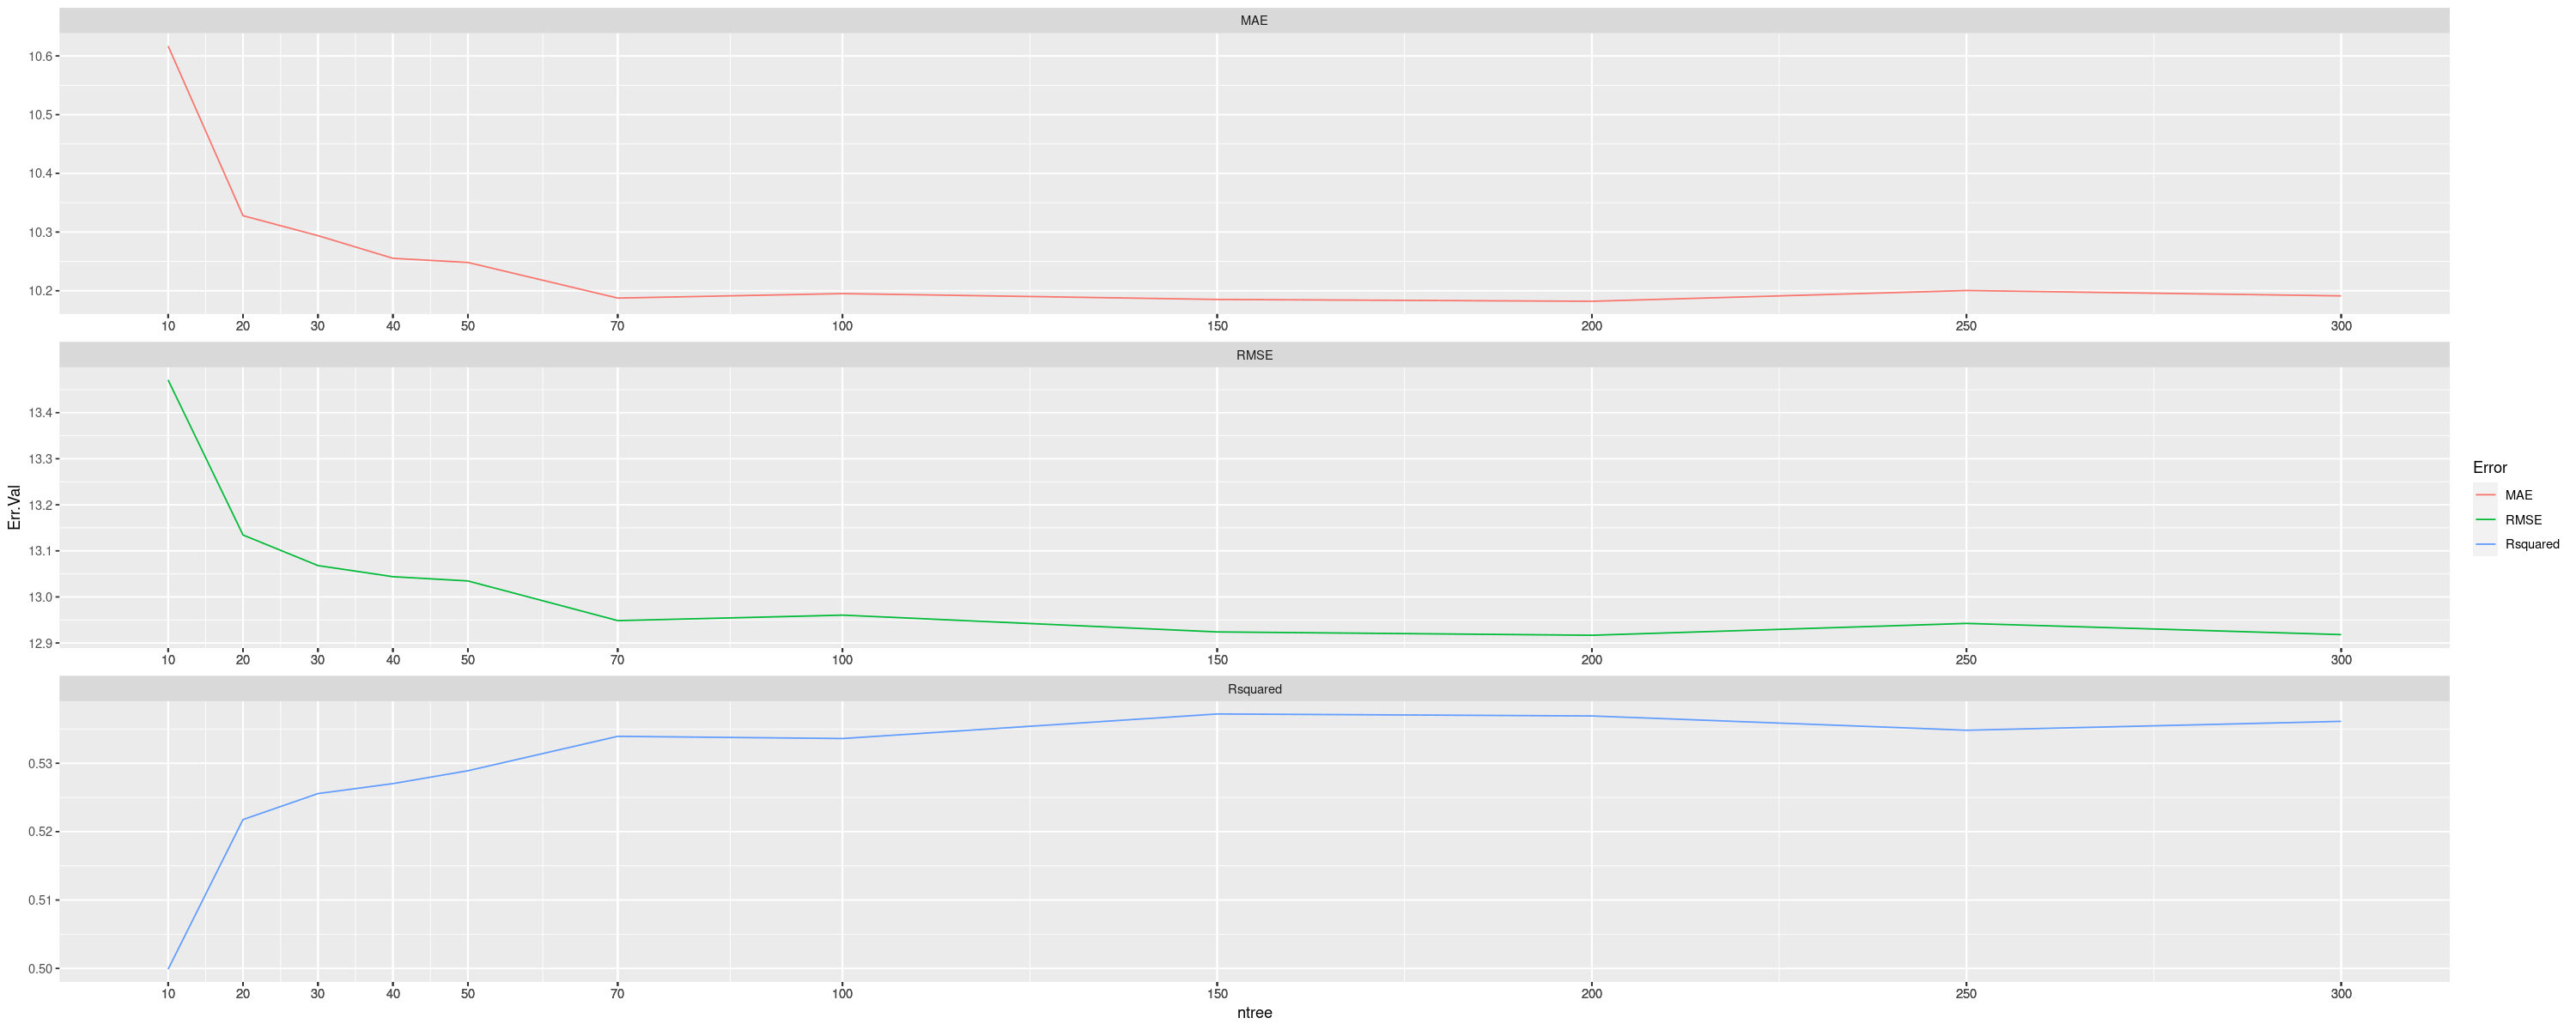

In [8]:
pivot.cv <- pivot_longer(data = cv, cols = 3:5, 
                         names_to = "Error", values_to = "Err.Val")

ggplot(pivot.cv, aes(x=ntree)) +
    geom_line(aes(y=Err.Val, color=Error)) +
    facet_wrap(~Error, scale="free", ncol=1) +
  scale_x_continuous(breaks = pivot.cv$ntree)

In [9]:
ggsave(
    "test.png",
    plot = last_plot(),
    device = "png",
    path = "plots/cross-validation/randomForest/",
    width=14,
    height=16
)